# Description

This code consist of 4 main sections:

- In the **"Setup"** section we define a class "opinion" which stores some parameters related to the electorate dynamics. 
- Method "testrun" simulates electorate dynamics only (without the candidates) and returns the final electorate distribution. Section **"Voter Dynamics"** uses this method to illustrate how electorate evolves.
- Method "two_candidate_run" simulates 2-candidate interaction with dynamic electorate and returns the positions of candidates in time (as well as time array). Section **"2-Candidate Interaction"** uses this method to simulate candidate dynamics under various parameter assumptions.
- Method "three_candidate_run" simulates 3-candidate interaction and returns the positions of all three candidates over time. Section **"3-Candidate Interaction"** demonstrates this scenario.

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Parameters
class opinion:
    def __init__(self, nu=0.25, sigma=0.02, gamma=1,
        f=lambda x: np.array([0 if abs(xx)>1 else pow(xx,2)*(2*abs(xx)-3)+1 for xx in x])) -> None:
        self.nu=nu
        self.sigma=sigma
        self.gamma=gamma
        self.f=f
    def reset_to_default(self):
        self.nu=0.25
        self.sigma=0.02
        self.gamma=1
        self.f=lambda x: np.array([0 if abs(xx)>1 else pow(xx,2)*(2*abs(xx)-3)+1 for xx in x])
    def report_parameters(self):
        print(f"nu: {self.nu}, sigma: {self.sigma}, gamma: {self.gamma}")
    def update_initial_distribution(self,f):
        self.f=f

    def testrun(self,m,n,T=10,
        grid=np.linspace(-1,1,int(1e5)),
        savetimes='last'):
        # parsing savetimes
        if savetimes=='last': savetimes=np.array([n])
        elif savetimes=='all': savetimes=np.arange(n+1)
        else: savetimes=np.array(savetimes)
        savetimes=savetimes[savetimes<=n]
        savetimes=savetimes[savetimes>=0]
        savetimes=np.unique(savetimes)
        savetimes=np.sort(savetimes)
        K=len(savetimes)
        j=0
        XOUT=np.empty((K,len(grid)))

        # main code
        eta=lambda z: np.maximum(0,(1-abs(z)/self.nu))
        dx=2/m
        X=np.linspace(-1+0.5*dx,1-0.5*dx,m+1)
        dt=T/(n if n else 1)
        w=self.f(X)
        w=w/sum(w)
        if savetimes[j]==0:
            XOUT[j,:]=sum([w[i]*np.exp(-pow(grid-X[i],2)/(2*self.sigma**2))/np.sqrt(2*np.pi*self.sigma**2) for i in range(m)])
            j+=1
        for i in range(n):
            k=X+0.5*dt*np.array([sum([w[j]*eta(X[j]-x)*(X[j]-x) for j in range(m)]) for x in X])
            X=X+dt*np.array([sum([w[j]*eta(k[j]-x)*(k[j]-x) for j in range(m)]) for x in k])
            if savetimes[j]==i+1:
                XOUT[j,:]=sum([w[i]*np.exp(-pow(grid-X[i],2)/(2*self.sigma**2))/np.sqrt(2*np.pi*self.sigma**2) for i in range(m)])
                j+=1
                if j==K: break
        return XOUT if K>1 else XOUT[0,:]
    
    def two_candidate_run(self,m,dt,L0=-1, R0=1, T=10, alpha=[1, 0.1], plotit=True):
        print("Two candidate run with parameters:")
        print(f" nu: {self.nu}, sigma: {self.sigma}, gamma: {self.gamma},",
              f"alpha: [{alpha[0]}, {alpha[1]}], T: {T}")
        eta=lambda z: max(0,(1-abs(z)/self.nu))
        dx=2/m
        ksi=np.sqrt(self.sigma**2+self.gamma**2)
        X=np.linspace(-1+0.5*dx,1-0.5*dx,m+1)
        # dt=T/(n if n else 1)
        n=int(T/dt)
        SL=np.empty(n+1)
        SR=np.empty(n+1)
        SL[0]=L0
        SR[0]=R0
        w=self.f(X)
        w=w/sum(w)
        hit=False
        for i in range(n):
            #
            k=X+0.5*dt*np.array([sum([w[j]*eta(X[j]-x)*(X[j]-x) for j in range(m)]) for x in X])
            dX=dt*np.array([sum([w[j]*eta(k[j]-x)*(k[j]-x) for j in range(m)]) for x in k])


            weighted_midpoint=(self.gamma/self.sigma)*(0.5*(SL[i]+SR[i])-X)
            midpoint_l=weighted_midpoint+0.5*(self.sigma/self.gamma)*(SR[i]-SL[i])
            midpoint_r=weighted_midpoint-0.5*(self.sigma/self.gamma)*(SR[i]-SL[i])
            dsl=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SL[i],2)/(2*ksi**2))*\
                (((X[j]-SL[i])/(2*ksi**3))*(1-erf(-midpoint_l[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_l[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsr=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SR[i],2)/(2*ksi**2))*\
                (((X[j]-SR[i])/(2*ksi**3))*(1+erf(-midpoint_r[j]/(np.sqrt(2)*ksi)))-\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_r[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            SL_mid=SL[i]+0.5*alpha[0]*dt*dsl
            SR_mid=SR[i]+0.5*alpha[1]*dt*dsr
            
           

            weighted_midpoint=(self.gamma/self.sigma)*(0.5*(SL_mid+SR_mid)-X-0.5*dX)
            midpoint_l=weighted_midpoint+0.5*(self.sigma/self.gamma)*(SR_mid-SL_mid)
            midpoint_r=weighted_midpoint-0.5*(self.sigma/self.gamma)*(SR_mid-SL_mid)
            dsl=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SL_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SL_mid)/(2*ksi**3))*(1-erf(-midpoint_l[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_l[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsr=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SR_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SR_mid)/(2*ksi**3))*(1+erf(-midpoint_r[j]/(np.sqrt(2)*ksi)))-\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_r[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            
            if hit and (alpha[0]*dsl>=alpha[1]*dsr):
                dcommon=0.5*(alpha[0]*dsl+alpha[1]*dsr)
                SL[i+1]=SL[i]+dt*dcommon
                SR[i+1]=SR[i]+dt*dcommon
            else:
                if hit: print('Candidates separated at timestep',i)
                hit=False
                SL[i+1]=SL[i]+alpha[0]*dt*dsl
                SR[i+1]=SR[i]+alpha[1]*dt*dsr
                if SL[i+1]>SR[i+1]:
                    common_value=0.5*(SL[i+1]+SR[i+1])
                    SL[i+1]=common_value
                    SR[i+1]=common_value
                    hit=True
                    print('Candidates met at timestep',i)
            X=X+dX
            
        time=np.linspace(0,n*dt,n+1)
        if plotit:
            plt.figure()
            plt.plot(time,SL,label='L')
            plt.plot(time,SR,label='R')
            plt.xlim(0,T)
            plt.legend()
        print('Candidates are', 'together' if hit else 'separated', 'at the end')
        print('----------------------------------')
        return SL,SR, time

    def three_candidate_run(self,m,dt,L0=-1, M0=0, R0=1, T=10, alpha=[1,0.4,0.4],plotit=True):
        print("Three candidate run with parameters:")
        print(f" nu: {self.nu}, sigma: {self.sigma}, gamma: {self.gamma},",
              f"alpha: [{alpha[0]}, {alpha[1]}, {alpha[2]}], T: {T}")
        eta=lambda z: max(0,(1-abs(z)/self.nu))
        dx=2/m
        ksi=np.sqrt(self.sigma**2+self.gamma**2)
        X=np.linspace(-1+0.5*dx,1-0.5*dx,m+1)
        #dt=T/(n if n else 1)
        n=int(T/dt)
        SL=np.empty(n+1)
        SM=np.empty(n+1)
        SR=np.empty(n+1)
        SL[0]=L0
        SM[0]=M0
        SR[0]=R0
        w=self.f(X)
        w=w/sum(w)

        hit=[False, False]
        for i in range(n):
            #
            k=X+0.5*dt*np.array([sum([w[j]*eta(X[j]-x)*(X[j]-x) for j in range(m)]) for x in X])
            dX=dt*np.array([sum([w[j]*eta(k[j]-x)*(k[j]-x) for j in range(m)]) for x in k])


            weighted_midpoint_lm=(self.gamma/self.sigma)*(0.5*(SL[i]+SM[i])-X)
            weighted_midpoint_mr=(self.gamma/self.sigma)*(0.5*(SM[i]+SR[i])-X)
            midpoint_l =weighted_midpoint_lm +0.5*(self.sigma/self.gamma)*(SM[i]-SL[i])
            midpoint_ml=weighted_midpoint_lm -0.5*(self.sigma/self.gamma)*(SM[i]-SL[i])
            midpoint_mr=weighted_midpoint_mr +0.5*(self.sigma/self.gamma)*(SR[i]-SM[i])
            midpoint_r =weighted_midpoint_mr -0.5*(self.sigma/self.gamma)*(SR[i]-SM[i])
            dsl=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SL[i],2)/(2*ksi**2))*\
                (((X[j]-SL[i])/(2*ksi**3))*(1-erf(-midpoint_l[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_l[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsm=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SM[i],2)/(2*ksi**2))*\
                (((X[j]-SM[i])/(2*ksi**3))*(erf(-midpoint_ml[j]/(np.sqrt(2)*ksi))-erf(-midpoint_mr[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*(np.exp(-midpoint_ml[j]**2/(2*ksi**2))-np.exp(-midpoint_mr[j]**2/(2*ksi**2)))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
                
            dsr=self.gamma*sum([w[j]*np.exp(-pow(X[j]-SR[i],2)/(2*ksi**2))*\
                (((X[j]-SR[i])/(2*ksi**3))*(1+erf(-midpoint_r[j]/(np.sqrt(2)*ksi)))-\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_r[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            SL_mid=SL[i]+0.5*alpha[0]*dt*dsl
            SM_mid=SM[i]+0.5*alpha[1]*dt*dsm
            SR_mid=SR[i]+0.5*alpha[2]*dt*dsr
            
           

            weighted_midpoint_lm=(self.gamma/self.sigma)*(0.5*(SL_mid+SM_mid)-X-0.5*dX)
            weighted_midpoint_mr=(self.gamma/self.sigma)*(0.5*(SM_mid+SR_mid)-X-0.5*dX)
            midpoint_l =weighted_midpoint_lm +0.5*(self.sigma/self.gamma)*(SM_mid-SL_mid)
            midpoint_ml=weighted_midpoint_lm -0.5*(self.sigma/self.gamma)*(SM_mid-SL_mid)
            midpoint_mr=weighted_midpoint_mr +0.5*(self.sigma/self.gamma)*(SR_mid-SM_mid)
            midpoint_r =weighted_midpoint_mr -0.5*(self.sigma/self.gamma)*(SR_mid-SM_mid)
            dsl=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SL_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SL_mid)/(2*ksi**3))*(1-erf(-midpoint_l[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_l[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsm=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SM_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SM_mid)/(2*ksi**3))*(erf(-midpoint_ml[j]/(np.sqrt(2)*ksi))-erf(-midpoint_mr[j]/(np.sqrt(2)*ksi)))+\
                (self.gamma**2-self.sigma**2)*(np.exp(-midpoint_ml[j]**2/(2*ksi**2))-np.exp(-midpoint_mr[j]**2/(2*ksi**2)))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
            dsr=self.gamma*sum([w[j]*np.exp(-pow(X[j]+0.5*dX[j]-SR_mid,2)/(2*ksi**2))*\
                (((X[j]+0.5*dX[j]-SR_mid)/(2*ksi**3))*(1+erf(-midpoint_r[j]/(np.sqrt(2)*ksi)))-\
                (self.gamma**2-self.sigma**2)*np.exp(-midpoint_r[j]**2/(2*ksi**2))/(self.gamma*self.sigma*np.sqrt(8*np.pi)*ksi**2)) for j in range(m)])
             
            if not any(hit):
                SL[i+1]=SL[i]+alpha[0]*dt*dsl
                SM[i+1]=SM[i]+alpha[1]*dt*dsm
                SR[i+1]=SR[i]+alpha[2]*dt*dsr
                if SL[i+1]>SR[i+1]:
                    common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                    SL[i+1]=common_value
                    SM[i+1]=common_value
                    SR[i+1]=common_value
                    hit=[True, True]
                    print('All met at timestep', i)
                elif SL[i+1]>SM[i+1]:
                    common_value=(SL[i+1]+SM[i+1])/2
                    SL[i+1]=common_value
                    SM[i+1]=common_value
                    hit[0]=True
                    print('LM met at timestep', i)
                elif SM[i+1]>SR[i+1]:
                    common_value=(SM[i+1]+SR[i+1])/2
                    SM[i+1]=common_value
                    SR[i+1]=common_value
                    hit[1]=True
                    print('MR met at timestep', i)
            elif all(hit): 
                if alpha[0]*dsl>=alpha[2]*dsr:
                    dcommon=(alpha[0]*dsl+alpha[1]*dsm+alpha[2]*dsr)/3 
                    SL[i+1]=SL[i]+dt*dcommon
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*dcommon 
                elif alpha[0]*dsl>=alpha[1]*dsm:
                    dcommon=(alpha[0]*dsl+alpha[1]*dsm)/2 
                    SL[i+1]=SL[i]+dt*dcommon
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*alpha[2]*dsr
                    hit[1]=False
                    print('R separated from LM at timestep', i)
                elif alpha[1]*dsm>=alpha[2]*dsr:
                    dcommon=(alpha[1]*dsm+alpha[2]*dsr)/2 
                    SL[i+1]=SL[i]+dt*alpha[0]*dsl
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*dcommon
                    hit[0]=False
                    print('L separated from MR at timestep', i)
                else:
                    SL[i+1]=SL[i]+dt*alpha[0]*dsl
                    SM[i+1]=SM[i]+dt*alpha[1]*dsm
                    SR[i+1]=SR[i]+dt*alpha[2]*dsr
                    hit=[False, False]
                    print('All separated at timestep', i)
            elif hit[0]:
                if alpha[0]*dsl>=alpha[1]*dsm:
                    dcommon=(alpha[0]*dsl+alpha[1]*dsm)/2 
                    SL[i+1]=SL[i]+dt*dcommon
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*alpha[2]*dsr
                    if SM[i+1]>SR[i+1]:
                        common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                        SL[i+1]=common_value
                        SM[i+1]=common_value
                        SR[i+1]=common_value
                        hit[1]=True
                        print('All met at timestep', i)
                else:
                    SL[i+1]=SL[i]+alpha[0]*dt*dsl
                    SM[i+1]=SM[i]+alpha[1]*dt*dsm
                    SR[i+1]=SR[i]+alpha[2]*dt*dsr
                    if SM[i+1]>SR[i+1]:
                        common_value=(SM[i+1]+SR[i+1])/2
                        SM[i+1]=common_value
                        SR[i+1]=common_value
                        hit[1]=True
                        
                        if SL[i+1]>SM[i+1]:
                            common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                            SL[i+1]=common_value
                            SM[i+1]=common_value
                            SR[i+1]=common_value
                            print('All met at timestep', i)
                        else:
                            hit[0]=False
                            print('LM separated and MR met at timestep', i)
                    else:
                        hit[0]=False
                        print('LM separated at timestep', i)
            else: 
                if alpha[1]*dsm>=alpha[2]*dsr:
                    dcommon=(alpha[1]*dsm+alpha[2]*dsr)/2 
                    SL[i+1]=SL[i]+dt*alpha[0]*dsl
                    SM[i+1]=SM[i]+dt*dcommon
                    SR[i+1]=SR[i]+dt*dcommon
                    if SL[i+1]>SM[i+1]:
                        common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                        SL[i+1]=common_value
                        SM[i+1]=common_value
                        SR[i+1]=common_value
                        hit[0]=True
                        print('All met at timestep', i)
                else:
                    SL[i+1]=SL[i]+alpha[0]*dt*dsl
                    SM[i+1]=SM[i]+alpha[1]*dt*dsm
                    SR[i+1]=SR[i]+alpha[2]*dt*dsr
                    if SL[i+1]>SM[i+1]:
                        common_value=(SL[i+1]+SM[i+1])/2
                        SL[i+1]=common_value
                        SM[i+1]=common_value
                        hit[0]=True
                                                
                        if SM[i+1]>SR[i+1]:
                            common_value=(SL[i+1]+SM[i+1]+SR[i+1])/3
                            SL[i+1]=common_value
                            SM[i+1]=common_value
                            SR[i+1]=common_value
                            print('All met at timestep', i)
                        else:
                            hit[1]=False
                            print('MR separated and LM met at timestep', i)
                    else:
                        hit[1]=False
                        print('MR separated at timestep', i)
                
                
            X=X+dX
        
        time=np.linspace(0,n*dt,n+1)
        if plotit:
            plt.figure()
            plt.plot(time,SL,label='L')
            plt.plot(time,SM,label='M')
            plt.plot(time,SR,label='R')
            plt.xlim(0,T)
            plt.legend()
        hit_value='All' if all(hit) else 'LM' if hit[0] else 'MR' if hit[1] else 'None'
        print(hit_value, 'are together at the end')
        print('----------------------------------')
        return SL,SM,SR, time

# Voter Dynamics

Let $X_1,X_2,\ldots,X_n \in \mathbb{R}$, and assume for now that the $X_i$ are the only opinions represented in the electorate. 
If $w_i$ is the fraction of individuals who hold opinion $X_i$, then the "density" of opinions altogether is the distribution
$$\sum_{i=1}^n w_i \delta(x-X_i),$$
where $\delta$ denotes the Dirac delta distribution. The condition that this be a probability measure becomes
$
\sum_{i=1}^n w_i =1.
$

We assume that the opinion holders in the $i$-th cluster, that is, opinion holders
with opinion $X_i$, find the opinions represented by other clusters persuasive especially if the other clusters are large and/or nearby in opinion
space:
$$\frac{dX_i}{dt} = 
\sum_{j=1}^n \eta(|X_j-X_i|) w_j (X_j-X_i)
$$
where 
$$
\eta: ~~  [0,\infty) \rightarrow [0,1]
$$
is a decreasing function with $\lim_{z \rightarrow \infty} \eta(z) = 0$, called the 
interaction function. 


save initial conditions
run simulation for T=300
run simulation for T=600


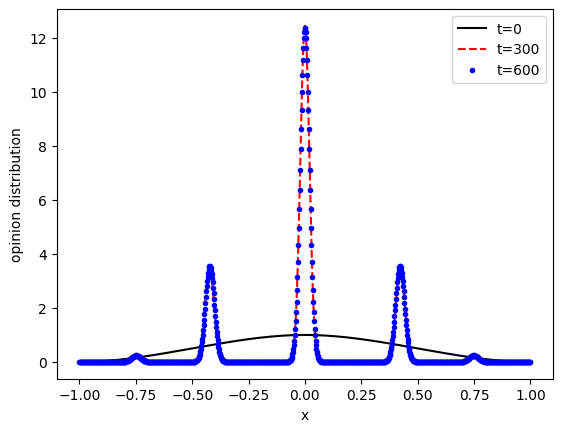

In [2]:
# figure 1
grid=np.linspace(-1,1,int(1e3))
op=opinion()
print('save initial conditions')
X0=op.testrun(100,0, grid=grid)
print('run simulation for T=300')
X1=op.testrun(100,150, T=300, grid=grid)
print('run simulation for T=600')
X2=op.testrun(200,600, T=600, grid=grid)
plt.plot(grid,X0,'k',label='t=0')
plt.plot(grid,X1,'r--',label='t=300')
plt.plot(grid,X2,'b.',label='t=600')
plt.legend()
plt.xlabel('x')
plt.ylabel('opinion distribution')
plt.savefig('Figures/fig1.pdf')
plt.savefig('Figures/fig1.png', dpi=600)

# 2-Candidate Interaction

We consider two political candidates, $L$ and $R$, with political positions $\ell$ and $r$, where $\ell<r$. We will 
study how the candidates might shift positions to increase their chance of winning elections. 

We assume that a voter whose position $x$ is closer to $\ell$ than to $r$ will vote for $L$, unless they abstain. Their probability
of voting (not abstaining) is taken to be 
$$e^{-(x-\ell)^2/(2 \gamma^2)}$$
 where $\gamma>0$ is a new model parameter measuring voter loyalty. Consequently the fraction of voters who 
will vote for $L$, if the election is held at time $t$, will be 
$$ S_L = S_L(\ell,r,t) = \int_{-\infty}^{(\ell+r)/2} f(x,t) e^{-(x-\ell)^2/(2 \gamma^2)} dx, $$
where $f$ denotes the probability density of voter positions. Analogously, 
$$
S_R = S_R(\ell,r,t) = \int_{(\ell+r)/2}^\infty f(x,t) e^{-(x-r)^2/(2\gamma^2)} dx.
$$
We assume that $L$ and $R$ optimize their position using continuous steepest descent: 
$$
\frac{d \ell}{dt} = \alpha \frac{\partial S_L}{\partial \ell}(\ell, r, t), ~~~ \frac{dr}{dt} = \beta \frac{\partial S_R}{\partial r} (\ell, r, t), 
$$
where $\alpha$ and $\beta$ are parameters measuring the
eagerness with which $L$ changes positions opportunistically. 



Two candidate run with parameters:
 nu: 0.3, sigma: 0.02, gamma: 1.12, alpha: [1, 0.1], T: 50
Candidates met at timestep 241
Candidates are together at the end
----------------------------------
Two candidate run with parameters:
 nu: 0.3, sigma: 0.02, gamma: 1.1, alpha: [1, 0.1], T: 50
Candidates met at timestep 246
Candidates separated at timestep 259
Candidates are separated at the end
----------------------------------
Two candidate run with parameters:
 nu: 0.3, sigma: 0.02, gamma: 1.08, alpha: [1, 0.1], T: 50
Candidates are separated at the end
----------------------------------


<Figure size 640x480 with 0 Axes>

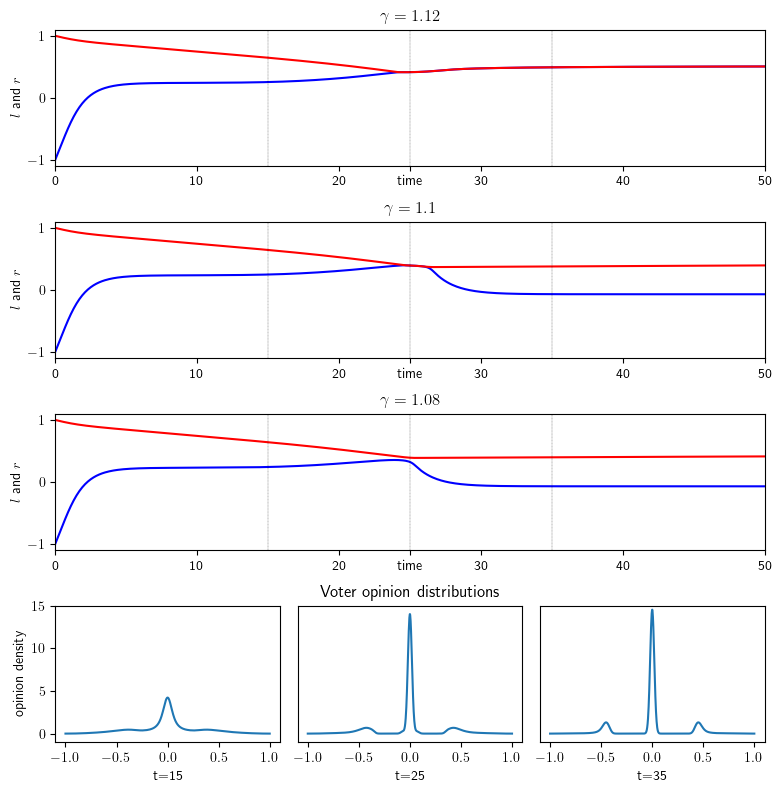

In [3]:
# Figure 2: Varying voter loyalty.
op=opinion(nu=0.3, gamma=1.12)
SL1, SR1, time1 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

op.gamma=1.1
SL2, SR2, time2 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

op.gamma=1.08
SL3, SR3, time3 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

grid=np.linspace(-1,1,int(1e3))
X=op.testrun(100, 400, T=40, grid=grid, savetimes=[150,250,350])

plt.figure()
plt.rc('text', usetex=True)
plt.figure(figsize=(8, 8))
plt.subplot(4,3,(1,3))
plt.plot(time1,SL1,label='L',color='b')
plt.plot(time1,SR1,label='R',color='r')
for t in [15, 25, 35]:
    plt.axvline(x=t, color='k', linestyle='--', linewidth=0.2)
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\gamma=1.12$')
plt.ylabel(r'$l$ and $r$')

plt.subplot(4,3,(4,6))
plt.plot(time2,SL2,label='L',color='b')
plt.plot(time2,SR2,label='R',color='r')
for t in [15, 25, 35]:
    plt.axvline(x=t, color='k', linestyle='--', linewidth=0.2)
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\gamma=1.1$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')

plt.subplot(4,3,(7,9))
plt.plot(time3,SL3,label='L',color='b')
plt.plot(time3,SR3,label='R',color='r')
for t in [15, 25, 35]:
    plt.axvline(x=t, color='k', linestyle='--', linewidth=0.2)
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\gamma=1.08$')
plt.ylabel(r'$l$ and $r$')
plt.tight_layout(pad=1.0)

plt.subplot(4,3,10)
plt.plot(grid,X[0])
plt.ylim(-1,15)
plt.ylabel('opinion density')
plt.xlabel('t=15')


plt.subplot(4,3,11)
plt.plot(grid,X[1])
plt.ylim(-1,15)
plt.yticks([])
plt.title('Voter opinion distributions')
plt.xlabel('t=25')

plt.subplot(4,3,12)
plt.plot(grid,X[2])
plt.ylim(-1,15)
plt.yticks([])
plt.xlabel('t=35')
plt.tight_layout(pad=1.0)

plt.savefig('Figures/fig2.pdf')
plt.savefig('Figures/fig2.png', dpi=600)

Two candidate run with parameters:
 nu: 0.25, sigma: 0.02, gamma: 1, alpha: [1, 0.1], T: 50
Candidates met at timestep 242
Candidates are together at the end
----------------------------------
Two candidate run with parameters:
 nu: 0.26, sigma: 0.02, gamma: 1, alpha: [1, 0.1], T: 50
Candidates met at timestep 249
Candidates separated at timestep 261
Candidates are separated at the end
----------------------------------
Two candidate run with parameters:
 nu: 0.27, sigma: 0.02, gamma: 1, alpha: [1, 0.1], T: 50
Candidates are separated at the end
----------------------------------


<Figure size 640x480 with 0 Axes>

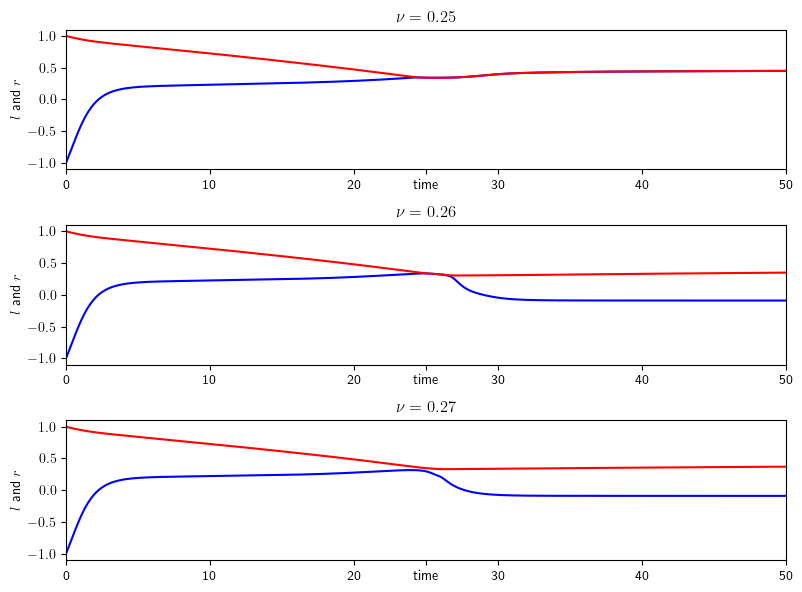

In [4]:
# figure 3: Varying voter open-mindedness.
op=opinion(nu=0.25, gamma=1)
SL1, SR1, time1 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

op.nu=0.26
SL2, SR2, time2 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

op.nu=0.27
SL3, SR3, time3 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.1], plotit=False)

plt.figure()
plt.rc('text', usetex=True)
plt.figure(figsize=(8, 6))
plt.subplot(3,1,1)
plt.plot(time1,SL1,label='L',color='b')
plt.plot(time1,SR1,label='R',color='r')
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\nu=0.25$')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,2)
plt.plot(time2,SL2,label='L',color='b')
plt.plot(time2,SR2,label='R',color='r')
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\nu=0.26$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,3)
plt.plot(time3,SL3,label='L',color='b')
plt.plot(time3,SR3,label='R',color='r')
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\nu=0.27$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')
plt.tight_layout(pad=1.0)

plt.savefig('Figures/fig3.pdf')
plt.savefig('Figures/fig3.png', dpi=600)


Two candidate run with parameters:
 nu: 0.3, sigma: 0.02, gamma: 1, alpha: [1, 0.39], T: 50
Candidates met at timestep 41
Candidates are together at the end
----------------------------------
Two candidate run with parameters:
 nu: 0.3, sigma: 0.02, gamma: 1, alpha: [1, 0.19], T: 50
Candidates met at timestep 124
Candidates separated at timestep 147
Candidates met at timestep 300
Candidates are together at the end
----------------------------------
Two candidate run with parameters:
 nu: 0.3, sigma: 0.02, gamma: 1, alpha: [1, 0.17], T: 50
Candidates are separated at the end
----------------------------------


<Figure size 640x480 with 0 Axes>

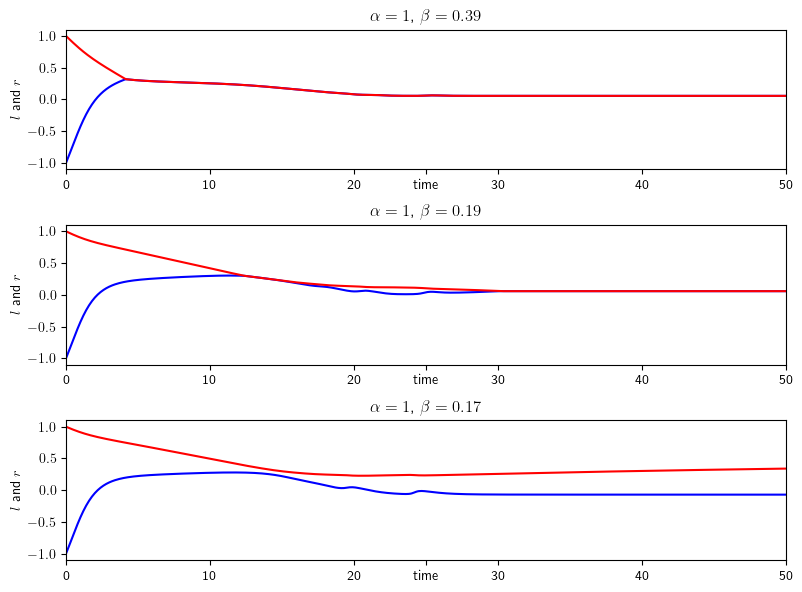

In [5]:
# figure 4: Varying candidate opportunism. 
op=opinion(nu=0.3, gamma=1)
SL1, SR1, time1 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.39], plotit=False)
SL2, SR2, time2 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.19], plotit=False)
SL3, SR3, time3 =op.two_candidate_run(100,0.1, T=50, alpha=[1, 0.17], plotit=False)


plt.figure()
plt.figure(figsize=(8, 6))
plt.rc('text', usetex=True)
plt.subplot(3,1,1)
plt.plot(time1,SL1,label='L',color='b')
plt.plot(time1,SR1,label='R',color='r')
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\alpha=1$, $\beta=0.39$')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,2)
plt.plot(time2,SL2,label='L',color='b')
plt.plot(time2,SR2,label='R',color='r')
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\alpha=1$, $\beta=0.19$')
plt.ylabel(r'$l$ and $r$')

plt.subplot(3,1,3)
plt.plot(time3,SL3,label='L',color='b')
plt.plot(time3,SR3,label='R',color='r')
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\alpha=1$, $\beta=0.17$')
#plt.xlabel('time')
plt.ylabel(r'$l$ and $r$')
plt.tight_layout(pad=1.0)

plt.savefig('Figures/fig4.pdf')
plt.savefig('Figures/fig4.png', dpi=600)

# 3-Candidate Interaction

With the introduction of a third candidate we need to adjust the voter shares earned by each candidate. Let us assume the three political candidates L, M, and R with positions $\ell$, $m$, and $r$, where $\ell<m<r$. Then their corresponding voter shares will be 

$$\begin{array}{rcl}
S_L = S_L(\ell,m,r,t) &=& \int_{-\infty}^{(\ell+m)/2} f(x,t) e^{-(x-\ell)^2/(2 \gamma^2)} dx, \\
S_M = S_M(\ell,m,r,t) &=& \int_{(\ell+m)/2}^{(m+r)/2} f(x,t) e^{-(x-m)^2/(2 \gamma^2)} dx, \\
S_R = S_R(\ell,m,r,t) &=& \int_{(m+r)/2}^{\infty} f(x,t) e^{-(x-r)^2/(2 \gamma^2)} dx.
\end{array}$$

Consequently, the equation for candidates' position optimizations become
$$
    \frac{d\ell}{dt}=\alpha\frac{\partial S_L}{d\ell}(\ell,m,r,t),\quad
    \frac{dm}{dt}=\kappa\frac{\partial S_M}{dm}(\ell,m,r,t),\quad 
\frac{dr}{dt}=\beta\frac{\partial S_R}{dr}(\ell,m,r,t).
$$



Three candidate run with parameters:
 nu: 0.25, sigma: 0.02, gamma: 1.08, alpha: [1, 0.2, 0.2], T: 50
LM met at timestep 57
LM separated at timestep 118
MR met at timestep 234
All met at timestep 354
L separated from MR at timestep 574
MR separated at timestep 585
None are together at the end
----------------------------------
Three candidate run with parameters:
 nu: 0.25, sigma: 0.02, gamma: 1.09, alpha: [1, 0.2, 0.2], T: 50
LM met at timestep 57
LM separated at timestep 118
MR met at timestep 234
All met at timestep 352
All are together at the end
----------------------------------


<Figure size 640x480 with 0 Axes>

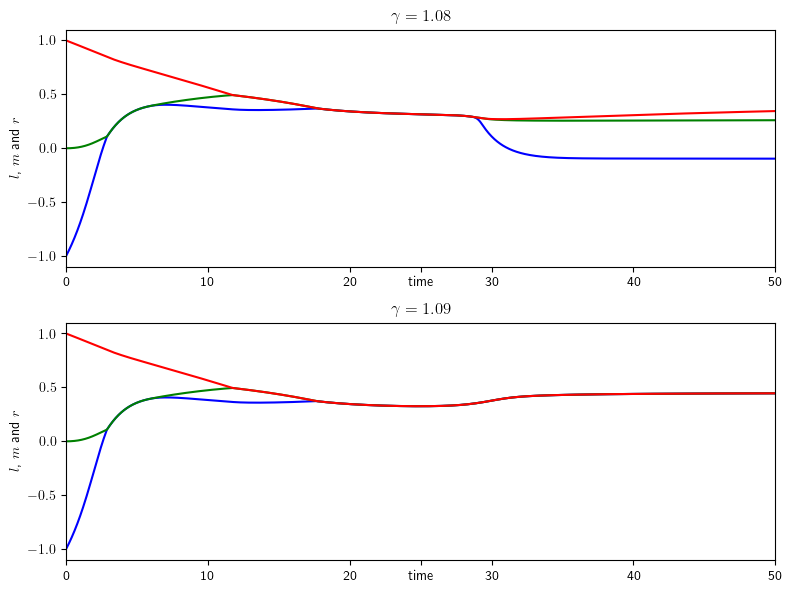

In [6]:
#figure 5: Varying voter loyalty in 3-candidate setting.
op=opinion(nu=0.25, gamma=1.08)
SL1, SM1, SR1, time1 =op.three_candidate_run(100,0.05, T=50, alpha=[1,0.2,0.2], plotit=False)
op.gamma=1.09
SL2, SM2, SR2, time2 =op.three_candidate_run(100,0.05, T=50, alpha=[1,0.2,0.2], plotit=False)

plt.figure()
plt.figure(figsize=(8, 6))
plt.rc('text', usetex=True)
plt.subplot(2,1,1)
plt.plot(time1,SL1,label='L',color='b')
plt.plot(time1,SM1,label='M',color='g')
plt.plot(time1,SR1,label='R',color='r')
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\gamma=1.08$')
plt.ylabel(r'$l$, $m$ and $r$')

plt.subplot(2,1,2)
plt.plot(time2,SL2,label='L',color='b')
plt.plot(time2,SM2,label='M',color='g')
plt.plot(time2,SR2,label='R',color='r')
plt.xlim(0,50)
plt.xticks(ticks=[0,10,20,25,30,40,50],
           labels=['0','10','20','time','30','40','50'])
plt.title(r'$\gamma=1.09$')
plt.ylabel(r'$l$, $m$ and $r$')
plt.tight_layout(pad=1.0)

plt.savefig('Figures/fig5.pdf')
plt.savefig('Figures/fig5.png', dpi=600)